epoch: 50 training loss: 0.6131085623055696 validation loss: 0.614086389541626 validation accuracy: 65 %
0


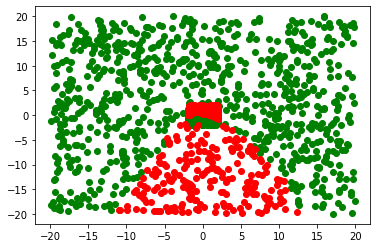

epoch: 100 training loss: 0.5534731242805719 validation loss: 0.5542222857475281 validation accuracy: 58 %
0


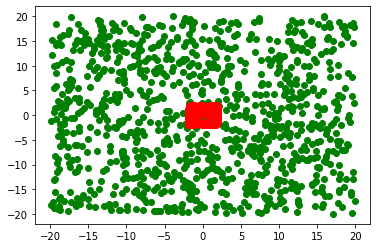

epoch: 150 training loss: 0.5424990691244602 validation loss: 0.5431984663009644 validation accuracy: 61 %
0


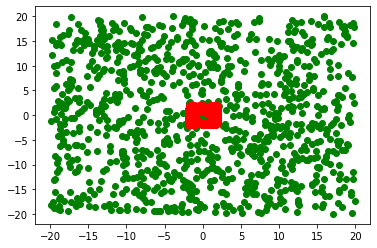

epoch: 200 training loss: 0.5354896653443575 validation loss: 0.5361372828483582 validation accuracy: 68 %
0


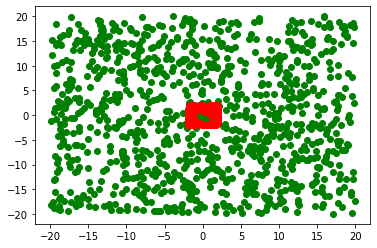

epoch: 250 training loss: 0.5290396008640528 validation loss: 0.5296621322631836 validation accuracy: 74 %
0


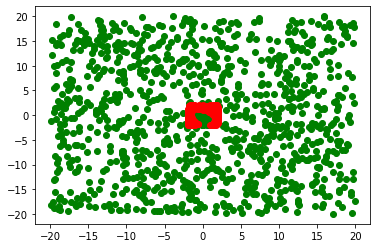

epoch: 300 training loss: 0.5229004807770252 validation loss: 0.5235061049461365 validation accuracy: 80 %
0


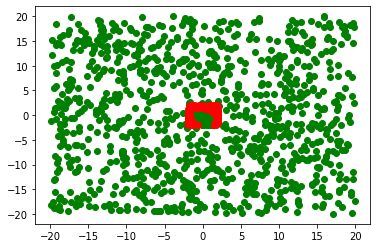

epoch: 350 training loss: 0.5170065183192492 validation loss: 0.5175966024398804 validation accuracy: 86 %
0


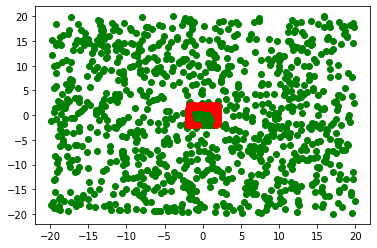

epoch: 400 training loss: 0.5113334013149142 validation loss: 0.5119073390960693 validation accuracy: 91 %
0


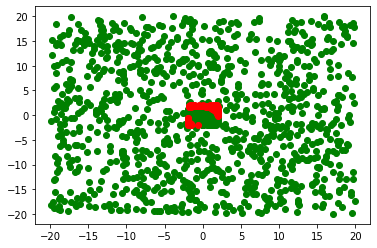

epoch: 450 training loss: 0.5058693904429674 validation loss: 0.5064241886138916 validation accuracy: 95 %
0


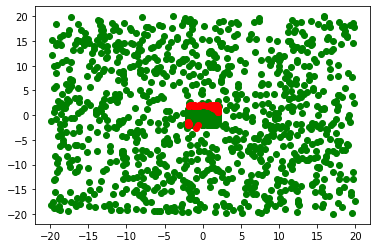

epoch: 500 training loss: 0.5006076516583562 validation loss: 0.5011425614356995 validation accuracy: 98 %
0


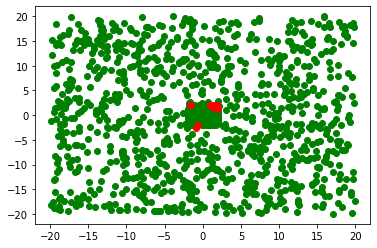

epoch: 550 training loss: 0.49554269667714834 validation loss: 0.496055006980896 validation accuracy: 99 %
0


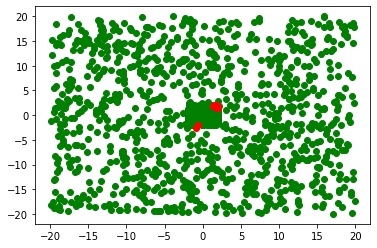

epoch: 600 training loss: 0.4906690726056695 validation loss: 0.4911580979824066 validation accuracy: 99 %
0


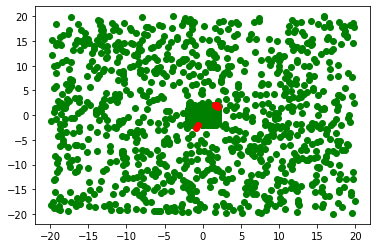

epoch: 650 training loss: 0.48598193377256393 validation loss: 0.48644641041755676 validation accuracy: 99 %
0


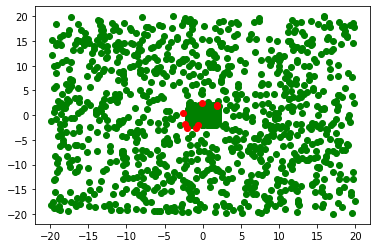

epoch: 700 training loss: 0.48147577699273825 validation loss: 0.4819141924381256 validation accuracy: 99 %
0


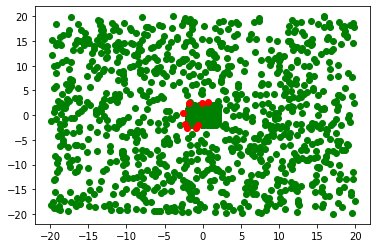

epoch: 750 training loss: 0.47714554239064455 validation loss: 0.47755733132362366 validation accuracy: 99 %
0


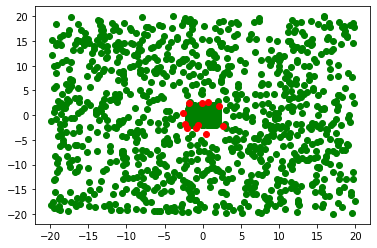

epoch: 800 training loss: 0.47298533748835325 validation loss: 0.47337040305137634 validation accuracy: 99 %
0


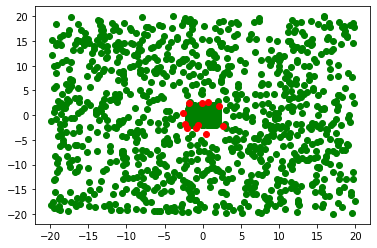

epoch: 850 training loss: 0.46898991242051125 validation loss: 0.46934667229652405 validation accuracy: 99 %
0


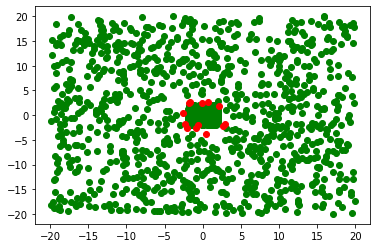

epoch: 900 training loss: 0.4651532219722867 validation loss: 0.46548232436180115 validation accuracy: 99 %
0


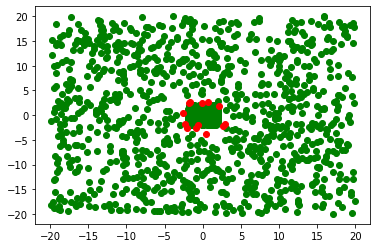

epoch: 950 training loss: 0.4614693224430084 validation loss: 0.4617697596549988 validation accuracy: 99 %
0


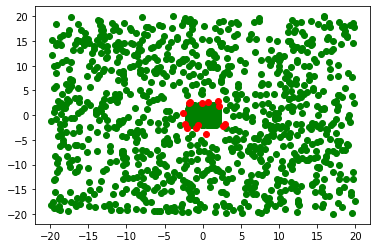

epoch: 1000 training loss: 0.457932211458683 validation loss: 0.4582042992115021 validation accuracy: 99 %
0


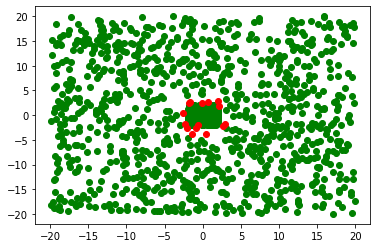

Training complete...


In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from MLP.imdb import DataSet

class Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables. Then we create the loss criterion and the optimizer and assign
        member variables.
        """
        #Initialize the torch.nn.Module superclass
        super().__init__()
        # Add your layers here with appropriate sizes...
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        # Construct our loss function and an Optimizer. The call to model.parameters()
        # in the SGD constructor will contain the learnable parameters of the two
        # nn.Linear modules which are members of the model.
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)

    def __call__(self, x):
        return self.forward(x)
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        Runs x through the first layer with H neurons then a ReLU activation
        Then x goes through the second layer with D_out neurons
        The output, a tensor of size 1xD_out called y_pred, is returned
        The prediction is also stored as a member variable so backward pass has less
        input parameters
        """
        #Compute x using each layer
        h_relu = F.relu(self.linear1(x))
        self.y_pred = F.sigmoid(self.linear2(h_relu))
        return self.y_pred

    def backward(self, y, printParams=False):
        """
        In the backwards pass, we accept a tensor for the labels, y. Then we compute
        the loss based on the criterion and the latest prediction.
        We store the loss as a member variable and we also return it to make it easy
        to read out the error while training.
        """
        # Compute and print loss
        self.loss = self.criterion(self.y_pred, y)
        # Zero the gradients
        self.optimizer.zero_grad()
        # Perform backwards pass
        self.loss.backward()
        if printParams:
            for param in self.parameters():
                print(param)
        # Update learnable weights
        self.optimizer.step()
        # Return the loss
        return self.loss

    def trainingLoop(self, x, y, xVal, yVal, epochs, batchSize, target_loss, printParams=False, printLoss=True, printStep=100):
        """
        The train function runs epochs number of forward and backwards passes
        on the training data {(xi, yi): xi in x and yi in y}.
        It compares the loss at each step with the target_loss. The function
        will halt training if it completes the given number of epochs or if the 
        target_loss is achieved, whichever comes first.
        This can be used to prevent overfitting.
        The printLoss boolean is used to print the loss each epoch or not.
        """
        #Training
        for step in range(epochs):
            self.running_loss = 0
            #Batches
            for i in range(batchSize):
                self.train()
                #Predict the output based on x, y_pred
                self.forward(x[i:x.shape[0]:batchSize])
                #compute the loss
                self.running_loss += self.backward(y[i:x.shape[0]:batchSize], printParams).item()
                
            self.running_loss /= batchSize

            #Print statistics...
            if printLoss and step % printStep == (printStep -1):
                #Validation testing...
                #Only validate when going to compute stats
                with torch.no_grad():
                    self.eval()
                    self.valY_pred = self.forward(xVal)
                    self.validLoss = self.criterion(self.valY_pred, yVal)
                correct = 0
                total = 0
                _, predicted = torch.max(self.valY_pred, 1)
                total += yVal.size(0)
                correct += (predicted == yVal).sum().item()
                #print(predicted)
                #print(total, correct)
                print('epoch:', step+1, 'training loss:', self.running_loss, 'validation loss:', self.validLoss.item(),
                      'validation accuracy: %d %%' % (100 * correct / total))
                """
                Create Plots showing accurate predictions vs false
                """
                truePointsx1 = np.array([])
                truePointsx2 = np.array([])
                falsePointsx1 = np.array([])
                falsePointsx2 = np.array([])
                print(truePointsx1.shape[0])
                for i in range(1,xVal.size(0),1):
                    if yVal[i] == predicted[i]:
                        if truePointsx1.shape[0] == 0:
                            truePointsx1 = np.array([xVal[i][0].numpy()])
                            truePointsx2 = np.array([xVal[i][1].numpy()])
                        else:
                            truePointsx1 = np.append(truePointsx1, np.array([xVal[i][0].numpy()]))
                            truePointsx2 = np.append(truePointsx2, np.array([xVal[i][1].numpy()]))
                    else:
                        if falsePointsx1.shape[0] == 0:
                            falsePointsx1 = np.array([xVal[i][0].numpy()])
                            falsePointsx2 = np.array([xVal[i][1].numpy()])
                        else:
                            falsePointsx1 = np.append(falsePointsx1, np.array([xVal[i][0].numpy()]))
                            falsePointsx2 = np.append(falsePointsx2, np.array([xVal[i][1].numpy()]))        
                plt.plot(truePointsx1, truePointsx2, 'go', falsePointsx1, falsePointsx2, 'ro')
                plt.show()
                
            #Early stopping
            if(self.running_loss <= target_loss):
                print("Target loss of " + str(target_loss) + " achieved, halting training")
                print("Current epoch: " + str(step))
                print("Current loss: " + str(self.loss.item()))
                break
    def test(self, x, y):
        with torch.no_grad():
            self.eval()
            self.testY_pred = self.forward(x)
            self.testLoss = self.criterion(self.testY_pred, y)
            print('loss:', self.testLoss.item())
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 2, 128, 2

# Create random Tensors to hold inputs and outputs
#x = torch.randn(N, D_in)
#y = torch.randn(N, D_out)

dataset_generator = DataSet(2, (0,0))
(X, Y) = dataset_generator.createDataset(5000, 5000)
x = torch.from_numpy(np.transpose(X)).type(torch.float)
y = torch.from_numpy(np.transpose(Y)).type(torch.long).reshape(-1)

(X, Y) = dataset_generator.createDataset(1000, 1000)
xVal = torch.from_numpy(np.transpose(X)).type(torch.float)
yVal = torch.from_numpy(np.transpose(Y)).type(torch.long).reshape(-1)

# Construct our model by instantiating the class defined above
model = Network(D_in, H, D_out)

model.trainingLoop(x, y, xVal, yVal, 1000, 32, 0.01, printParams=False,  printStep=50)

print('Training complete...')


In [ ]:
print(np.transpose(X).shape)
print(x.shape)
print(y.shape)
print(torch.max(y, 1)[1])
print(y)